In [1]:
import pandas as pd
import geopandas
import math

from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, LpStatus, value

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 1. Read Dataset

In [2]:
%run preprocessing.ipynb

In [3]:
dataset_df = pd.read_csv("../dataset/dataset.csv")
dataset_df

,city_code,name,region,lat,lon,population,demand
0,1,Adana,TR62_Adana_alt_bölgesi,36.991400,35.330800,2274106,45482.0
1,1,Adana_Aladağ,TR62_Adana_alt_bölgesi,37.546379,35.402962,15897,318.0
2,1,Adana_Ceyhan,TR62_Adana_alt_bölgesi,37.031700,35.822750,158922,3170.0
3,1,Adana_Feke,TR62_Adana_alt_bölgesi,37.819918,35.272100,15833,318.0
4,1,Adana_İmamoğlu,TR62_Adana_alt_bölgesi,37.258751,35.672840,27037,537.0
...,...,...,...,...,...,...,...
764,81,Düzce_Cumayeri,TR42_Kocaeli_alt_bölgesi,40.873871,30.949057,15214,299.0
765,81,Düzce_Gölyaka,TR42_Kocaeli_alt_bölgesi,40.776579,30.995727,20552,417.0
766,81,Düzce_Gümüşova,TR42_Kocaeli_alt_bölgesi,40.850000,30.933333,16844,339.0
767,81,Düzce_Kaynaşlı,TR42_Kocaeli_alt_bölgesi,40.777337,31.303267,20449,415.0


### 2. Customers, and Warehouses

In [4]:
RANDOM_STATE = 0          # For reproducibility
FRACTION_WAREHOUSES = 0.2 # Fraction of cities we want to keep as warehouse locations
FRACTION_CUSTOMERS = 0.9 # Fraction of cities we want to keep as customers

# Create the warehouses dataframe:
#   1. Sample a fraction of the original cities
warehouse_df = dataset_df.sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)

# Create the customers dataframe:
#   1. Sample a fraction of the original cities
customer_df = dataset_df.sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE+1, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])

Add geocoordinates

In [5]:
def add_geocoordinates(df, lat='lat', lon='lon'):
    """
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    """
    assert pd.Series([lat, lon]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lon}" in the input dataframe.'
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))


customer_df = add_geocoordinates(customer_df)
warehouse_df = add_geocoordinates(warehouse_df)

### 3. Customer and Potential Warehouse Locations

C:\Users\HasanErdemAK\AppData\Local\Temp\ipykernel_11852\3380377267.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


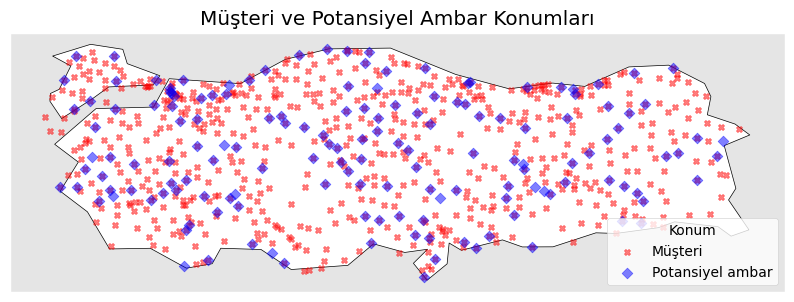

In [6]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Turkey
turkey = world[world.name == 'Turkey']
ax = turkey.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot customers as points
customer_df.plot(ax=ax, marker='X', color='red', markersize=20, alpha=0.5, label='Müşteri')

# Plot potential warehouse locations as points
warehouse_df.plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potansiyel ambar')

# Add legend
plt.legend(facecolor='white', title='Konum')

# Add title
plt.title('Müşteri ve Potansiyel Ambar Konumları')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

### 5. Annual Demand by Region

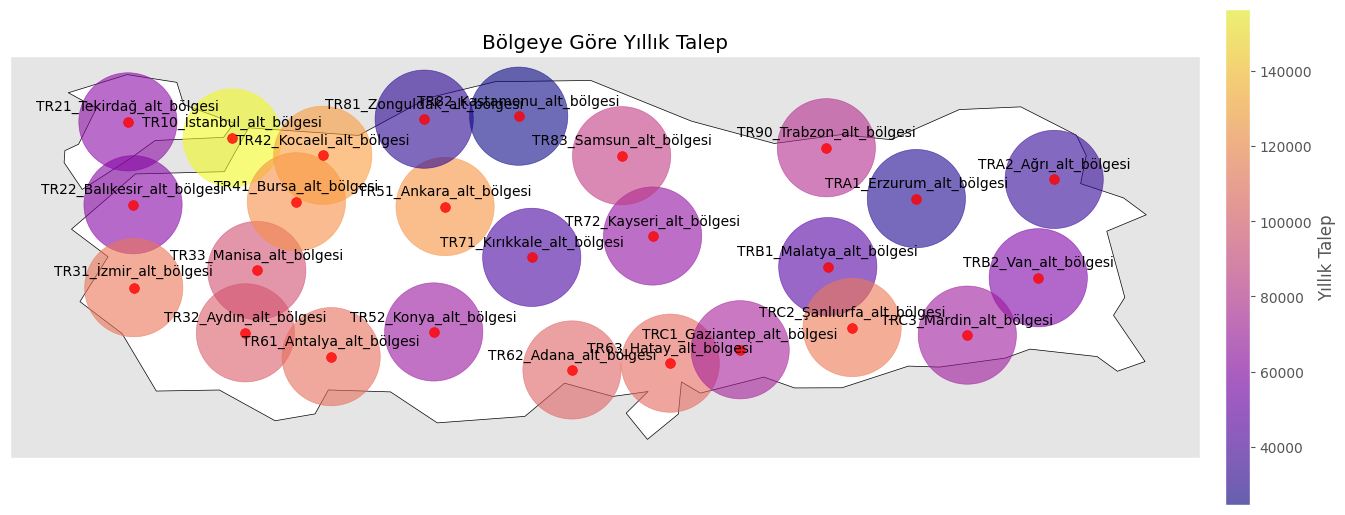

In [7]:
# Prepare region dataframe:
#   1. Group by region
#   2. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = dataset_df.\
             groupby(['region']).\
             agg({'lat': 'mean', 'lon': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of Italy
ax = turkey.plot(color='white', edgecolor='black', figsize=(16, 16))

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='talep', cmap='plasma', markersize=5000, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=50, alpha=0.8, label='Müşteri konumu')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.region, xy=(row.lon, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Yıllık Talep', fraction=0.02, pad=0.02) 

# Add title
plt.title('Bölgeye Göre Yıllık Talep')
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [8]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }

### 6. Supply and fixed costs

In [9]:
# Assumptions: 
#    1. Each warehouse has an annual rental cost of 500.000,00 TL
#    1. Each warehouse has an annual personel cost of 700.000,00 TL
#    2. Each warehouse can meet 3 times the regional average annual demand
RENTAL_COST_PER_WAREHOUSE = 500_000
PERSONNEL_COST_PER_WAREHOUSE = 700_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
warehouse_df['warehouse_id'] = [f'Ambar {i}' for i in range(1, 1 + warehouse_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in warehouse_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = {}
# For each warehouse location
for i in range(0, warehouse_df.shape[0]):
    is_city = False if warehouse_df.name[i].__contains__("_") else True
    # Update costs for warehouse i
    rental_cost_multiplier = 3 if is_city else 1
    personnel_cost_multiplier = 3 if is_city else 1

    annual_cost = rental_cost_multiplier * RENTAL_COST_PER_WAREHOUSE +\
                personnel_cost_multiplier * PERSONNEL_COST_PER_WAREHOUSE
    
    annual_cost_dict.update({warehouse_df.warehouse_id[i]: annual_cost})

### 7. Transportation costs

##### 7.1 Haversine distance

In [10]:
# Calculate the distance in km between two locations given latitude and longitude.
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # Convert latitude and longitude to radians
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    theta1 = lon1*degrees_to_radians
    theta2 = lon2*degrees_to_radians
    
    # Compute spherical distance from spherical coordinates
    cos = (math.cos(phi1)*math.cos(phi2)+
           math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2))
    arc = math.acos(cos)
    
    # Multiply arc by the radius of the earth to get length.
    return arc * 6371 # earth radius in km

##### 7.2 Calculate transportation costs

In [11]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, warehouse_df.shape[0]):
    is_city = False if warehouse_df.name[i].__contains__("_") else True
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
            # Distance in Km between warehouse i and customer j
        d = 0 if warehouse_df.name[i]==customer_df.name[j] else haversine(
            warehouse_df.lat[i], warehouse_df.lon[i], customer_df.lat[j], customer_df.lon[j])
        
        # Update costs for warehouse i
        transport_cost_multiplier = 1 if is_city else 2
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: d * transport_cost_multiplier})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict.update({warehouse_df.warehouse_id[i]: warehouse_transport_costs_dict})

### 8. Optimization

In [12]:
# Define linear problem
lp_problem = LpProblem('CFLP', LpMinimize)

# Variable: y_j (constraint: it is binary)
created_warehouse = LpVariable.dicts(
    'Create_warehouse', warehouse_df['warehouse_id'], 0, 1, LpBinary)

# Variable: x_ij
served_customer = LpVariable.dicts(
    'Link', [(i,j) for i in customer_df['customer_id'] for j in warehouse_df['warehouse_id']], 0)


# Objective function 
objective = lpSum(annual_cost_dict[j]*created_warehouse[j] for j in warehouse_df['warehouse_id']) +\
            lpSum(transport_costs_dict[j][i]*served_customer[(i,j)] \
                  for j in warehouse_df['warehouse_id'] for i in customer_df['customer_id'])

lp_problem += objective

# Costraint: the demand must be met
for i in customer_df['customer_id']:
    lp_problem += lpSum(served_customer[(i,j)] for j in warehouse_df['warehouse_id']) == demand_dict[i]

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in warehouse_df['warehouse_id']:
    lp_problem += lpSum(served_customer[(i,j)] for i in customer_df['customer_id']) <= \
    annual_supply_dict[j] * created_warehouse[j]

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in warehouse_df['warehouse_id']:
        lp_problem += served_customer[(i,j)] <= demand_dict[i] * created_warehouse[j]

In [13]:
lp_problem.solve()

1

In [14]:
print('Solution: ', LpStatus[lp_problem.status])

Solution:  Optimal


### 9. Explore the results

In [15]:
print(f"Total cost: {value(lp_problem.objective)}")

Total cost: 193751944.89283472


In [16]:
# List of the values assumed by the binary variable created_warehouse
warehouse_values = [i.varValue for i in created_warehouse.values()]

# Count of each distinct value of the list
[[i, warehouse_values.count(i)] for i in set(warehouse_values)]

[[0.0, 127], [1.0, 27]]

In [17]:
# Create dataframe column to store whether to build the warehouse or not 
warehouse_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in warehouse_df['warehouse_id']:
    if created_warehouse[i].varValue == 1:
        print(f"İnşaat sahası: {i} ({warehouse_df.loc[warehouse_df['warehouse_id'] == i, 'name'].values[0]})")
        warehouse_df.loc[warehouse_df['warehouse_id'] == i, 'build_warehouse'] = 'Evet'
    else:
        warehouse_df.loc[warehouse_df['warehouse_id'] == i, 'build_warehouse'] = 'Hayır'

İnşaat sahası: Ambar 32 (Tokat_Yeşilyurt)
İnşaat sahası: Ambar 33 (Van)
İnşaat sahası: Ambar 41 (İstanbul_Eyüpsultan)
İnşaat sahası: Ambar 46 (Burdur_Çavdır)
İnşaat sahası: Ambar 49 (Erzurum)
İnşaat sahası: Ambar 55 (Kütahya)
İnşaat sahası: Ambar 63 (Edirne_Lalapaşa)
İnşaat sahası: Ambar 77 (Hatay)
İnşaat sahası: Ambar 83 (Aydın_Buharkent)
İnşaat sahası: Ambar 84 (Çanakkale_Gelibolu)
İnşaat sahası: Ambar 85 (Zonguldak)
İnşaat sahası: Ambar 87 (Mersin)
İnşaat sahası: Ambar 89 (Malatya)
İnşaat sahası: Ambar 90 (Tekirdağ_Çorlu)
İnşaat sahası: Ambar 93 (Trabzon)
İnşaat sahası: Ambar 102 (Bursa_İnegöl)
İnşaat sahası: Ambar 105 (Çorum_Mecitözü)
İnşaat sahası: Ambar 113 (Samsun_19 Mayıs)
İnşaat sahası: Ambar 126 (Aksaray_Eskil)
İnşaat sahası: Ambar 127 (Ordu_Ünye)
İnşaat sahası: Ambar 130 (Aksaray_Gülağaç)
İnşaat sahası: Ambar 132 (Ankara)
İnşaat sahası: Ambar 133 (İstanbul_Pendik)
İnşaat sahası: Ambar 143 (Siirt)
İnşaat sahası: Ambar 144 (Antalya_Manavgat)
İnşaat sahası: Ambar 148 (Kocaeli_K

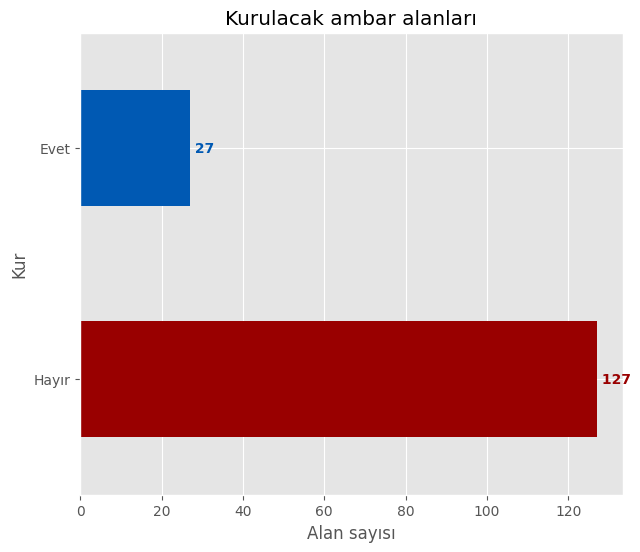

In [18]:
colors = ['#990000', '#0059b3']

warehouse_df.build_warehouse.value_counts().sort_index(axis=0, ascending=False).plot.barh(
  title='Kurulacak ambar alanları', xlabel='Alan sayısı', color=colors, ylabel='Kur', figsize=(7,6)) 

for i, v in enumerate(warehouse_df.build_warehouse.value_counts().sort_index(axis=0, ascending=False)):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')


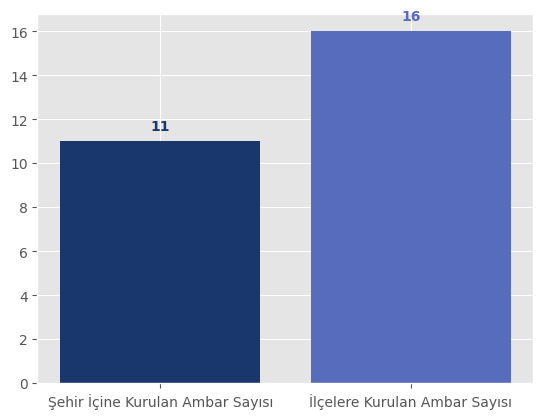

In [19]:
# function to add value labels
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.5, y[i], ha='center', color=colors[i], fontweight='bold')

colors = ['#19376D', '#576CBC']

x = ["Şehir İçine Kurulan Ambar Sayısı", "İlçelere Kurulan Ambar Sayısı"]
y = [
    warehouse_df.loc[~warehouse_df['name'].str.contains('_')].build_warehouse.value_counts().iloc[0],
    warehouse_df.loc[warehouse_df['name'].str.contains('_')].build_warehouse.value_counts().iloc[1]
]

plt.bar(x, y, color=colors)
addlabels(x, y)
plt.show()

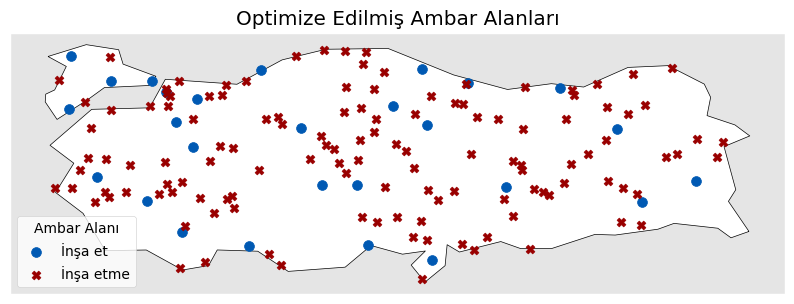

In [20]:
# Plot the shape of Italy
ax = turkey.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
warehouse_df.\
    loc[warehouse_df.build_warehouse =='Evet'].\
    plot(ax=ax, marker='o', c='#0059b3', markersize=50, label='İnşa et')

# Plot sites to discard
warehouse_df.\
    loc[warehouse_df.build_warehouse =='Hayır'].\
    plot(ax=ax, marker='X', c='#990000', markersize=40, label='İnşa etme')

# Add title
plt.title('Optimize Edilmiş Ambar Alanları')

# Add legend
plt.legend(title='Ambar Alanı', facecolor='white')

plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

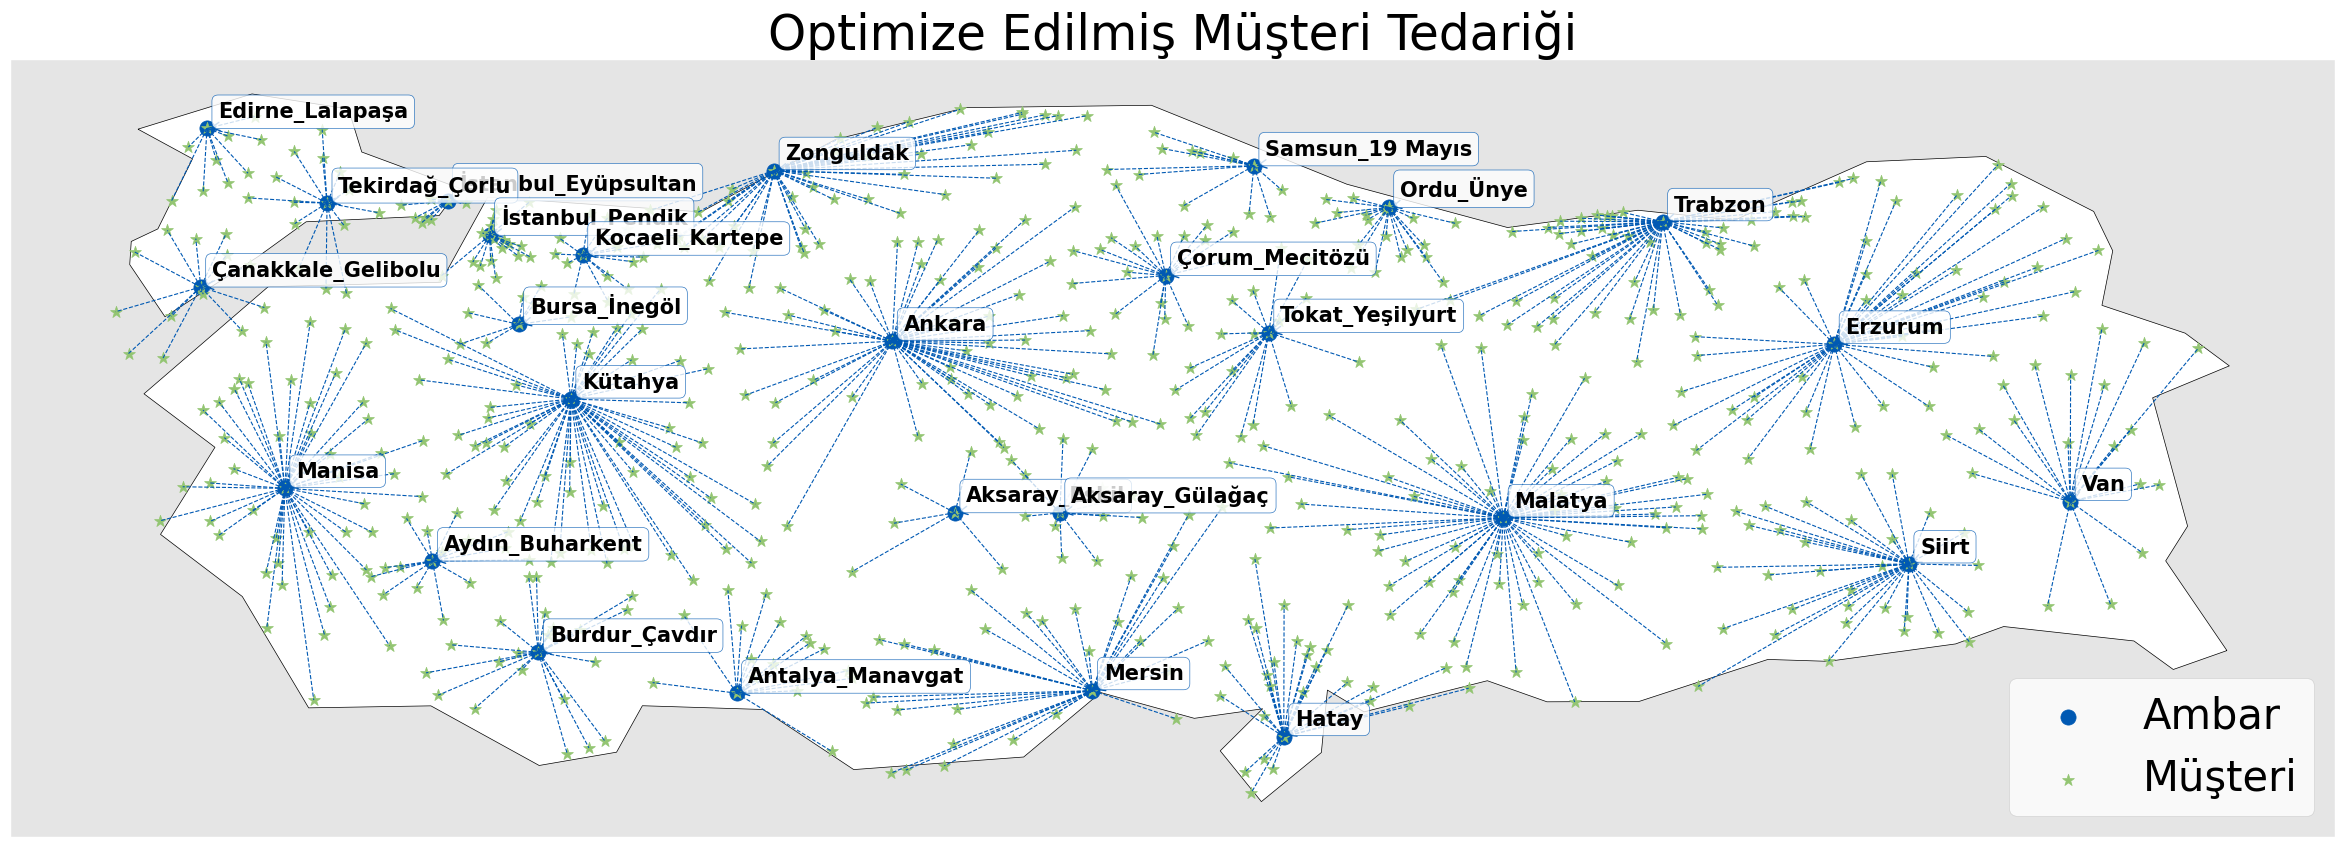

In [21]:
#Find customer ids that are served by the input warehouse.
def get_linked_customers(input_warehouse):
    # Initialize empty list
    linked_customers = []
    
    # Iterate through the xij decision variable
    for (k, v) in served_customer.items():
            
            # Filter the input warehouse and positive variable values
            if k[1]==input_warehouse and v.varValue>0:
                
                # Customer is served by the input warehouse
                linked_customers.append(k[0])

    return linked_customers


# Warehouses to establish
establish = warehouse_df.loc[warehouse_df.build_warehouse =='Evet']

# Plot the shape of Italy
ax = turkey.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish.\
    plot(ax=ax, marker='o', c='#0059b3', markersize=120, label='Ambar')

# Plot customers
customer_df.\
    plot(ax=ax, marker='*', color='#93C572', markersize=80, alpha=1, label='Müşteri')

# For each warehouse to build
for _, row in establish.iterrows():
    w = row['warehouse_id']

    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)

    # For each served customer
    for c in linked_customers:

        customer_lon = customer_df.iloc[customer_df.index[customer_df.customer_id == c][0]].lon
        customer_lat = customer_df.iloc[customer_df.index[customer_df.customer_id == c][0]].lat

        # Plot connection between warehouse and the served customer
        ax.plot(
            [row['lon'], customer_lon],
            [row['lat'], customer_lat],
            linewidth=0.8, linestyle='--', color='#0059b3')

    # Add warehouse name as label
    ax.annotate(
        row['name'],
        xy=(row['lon'], row['lat']),
        xytext=(row['lon'] + 0.1, row['lat'] + 0.1),
        fontsize=15,
        fontweight='bold',
        arrowprops=dict(arrowstyle='->', linewidth=1, color='#0059b3'),
        bbox=dict(facecolor='white', edgecolor='#0059b3', boxstyle='round', alpha = 0.8))

# Add title
plt.title('Optimize Edilmiş Müşteri Tedariği', fontsize = 35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

### 10. Export Results

In [22]:
establish.to_csv("../output/optimized_warehouse_locations.csv")